## Objetivo
Investigar o defeito de desbalanceamento usando análises comparativas

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [134]:
df = pd.read_csv('../data.csv')
# separa apenas amostras com defeito de DESBALANCEAMENTO
df =  df.query("defeito == 'desbalanceamento' or defeito == 'normal'")
# descarta a coluna 'defeito', agora redundante
df.pop('defeito')
# reinicia o index
df = df.reset_index(drop=True)
# descarta a coluna 'rotacao' pois a velocidade extraída do tacometro representa melhor o rotor
df.pop('rotacao')

print('Amostras: {} \nColunas: {}'.format(df.shape[0], df.shape[1]))

Amostras: 382 
Colunas: 56


In [28]:
# isola o acelerômetro um, sentido tangencial
df_tg1 = df[['severidade', 'fundamental', 'tg1_1h', 'tg1_rms']]
df_tg1.head()

,severidade,fundamental,tg1_1h,tg1_rms
0,10.0,13.6272,0.426607,3.332768
1,10.0,14.2284,0.420370,3.388859
2,10.0,15.4308,0.561698,3.841905
3,10.0,16.2324,0.891638,3.830312
4,10.0,16.8336,1.128674,4.325995


## Variação em função da velocidade

Primeiramente, será tomada a amostra com maior severidade de desbalanceamento (35g)

In [31]:
df_tg1_35g = df_tg1.query("severidade == '35'")
df_tg1_35g.pop('severidade')
df_tg1_35g = df_tg1_35g.melt(id_vars='fundamental')
df_tg1_35g

,fundamental,variable,value
0,11.8236,tg1_1h,0.618379
1,13.4268,tg1_1h,0.975980
2,14.2284,tg1_1h,1.728877
3,15.4308,tg1_1h,2.889198
4,16.2324,tg1_1h,3.862888
...,...,...,...
85,51.3024,tg1_rms,52.662464
86,51.7032,tg1_rms,51.227817
87,53.3064,tg1_rms,53.201575
88,53.9076,tg1_rms,53.150297


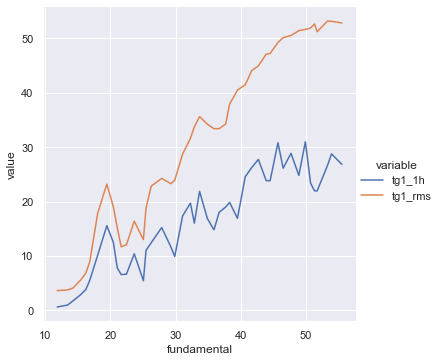

In [33]:
sns.relplot(data=df_tg1_35g, x='fundamental', y='value', hue='variable', kind='line');

<AxesSubplot:xlabel='fundamental', ylabel='value'>

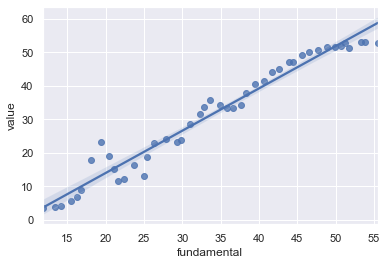

In [35]:
sns.regplot(data=df_tg1_35g.query("variable == 'tg1_rms'"), x='fundamental', y='value')

Como exposto, o nível de vibração tende a crescer linearmente com a velocidade de rotação. No entanto, há um comportamento estranho próximo à 20 Hz. 
No eixo tangencial, mas desta vez no acelerômetro 2, o comportamento se repete, indicando uma possível velocidade de ressonância.

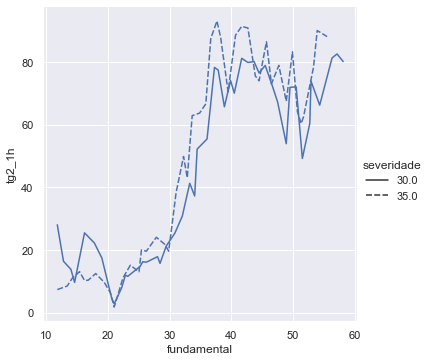

In [81]:
sns.relplot(
    data=df[['severidade', 'fundamental', 'tg2_1h']].query("severidade == 35 | severidade == 30"),
    x='fundamental', y='tg2_1h', style='severidade', kind='line'
);

Desta vez, verificamos que ele de fato ocorre com todos os graus de seeveridade.

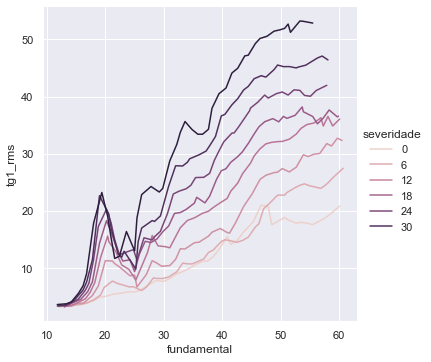

In [39]:
sns.relplot(data=df_tg1.drop('tg1_1h', axis=1), x='fundamental', y='tg1_rms', hue='severidade', kind='line');

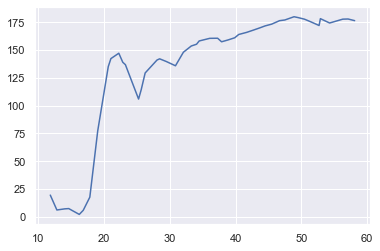

In [137]:
def unwrap_deg(degrees):
    return np.rad2deg(np.unwrap(np.deg2rad(degrees)))

plt.plot(df.query('severidade == 30')['fundamental'], df.query('severidade == 30')['tg1_phase'])

Quando mudamos o eixo para o radial, por exemplo, o comportamento se repete, mas no patamar próximo de 25 Hz

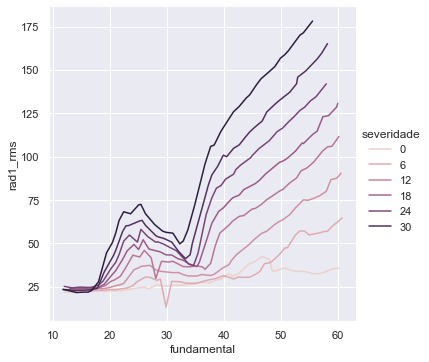

In [71]:
sns.relplot(
    data=df[['severidade', 'fundamental', 'rad1_rms']],
    x='fundamental', y='rad1_rms', hue='severidade', kind='line'
);

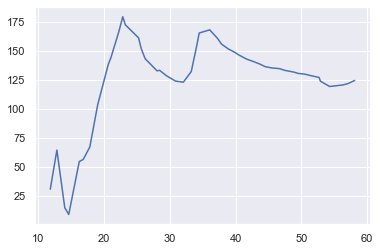

In [136]:
plt.plot(df.query('severidade == 30')['fundamental'], df.query('severidade == 30')['rad1_phase'])

# Variação em função da severidade (fixada a velocidade)

In [42]:
print('Representantes: ')

for severidade in df_tg1['severidade'].unique():
    subset = df_tg1.query('severidade == {}'.format(severidade))
    print('    {:2.0F} g -'.format(severidade), subset['fundamental'].iloc[44])


Representantes: 
    10 g - 57.9156
    15 g - 57.3144
    20 g - 56.3124
    25 g - 55.11
    30 g - 56.3124
    35 g - 55.5108
     6 g - 56.9136
     0 g - 56.7132


In [131]:
# seleciona representates na faixa desejada
df_tg1_55hz = df_tg1.query("fundamental > 54.8 & fundamental < 56.4").drop([140, 190])
df_tg1_55hz.pop('fundamental')

# tabula de forma cumprida
df_tg1_55hz = df_tg1_55hz.melt(id_vars='severidade')

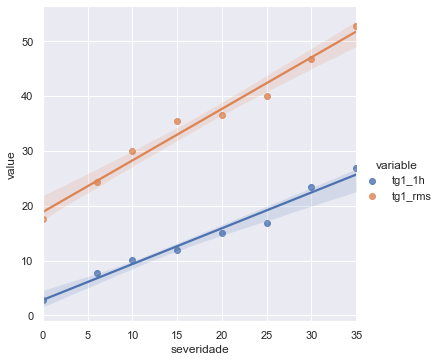

In [44]:
sns.lmplot(data=df_tg1_55hz, x='severidade', y='value', hue='variable');

Nota-se uma relação linear entre a vibração no eixo tangencial e o grau de severidade do desbalanceamento.
Este comportamento se repete para todas as velocidades?

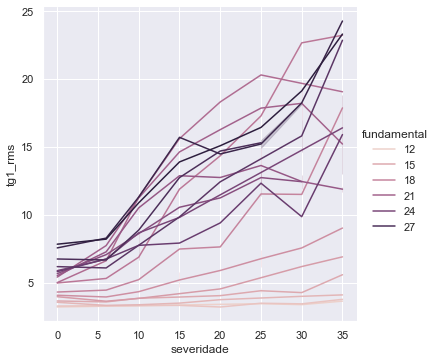

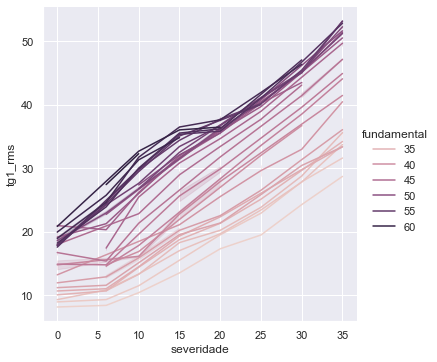

In [45]:
df_tg1_round = df_tg1.drop('tg1_1h', axis=1).copy(deep=True)
df_tg1_round['fundamental'] = df_tg1['fundamental'].apply(round)

sns.relplot(
    data=df_tg1_round.query('fundamental < 30'), 
    x='severidade', y='tg1_rms', hue='fundamental', kind='line',
);

sns.relplot(
    data=df_tg1_round.query('fundamental > 30'), 
    x='severidade', y='tg1_rms', hue='fundamental', kind='line',
);

Em geral, para velocidades acima de 30 Hz o comportamento é linear. Abaixo de 30 Hz há certa desordem nos dados.

Em seguida, normalizamos os dados em relação à velocidade de rotação.

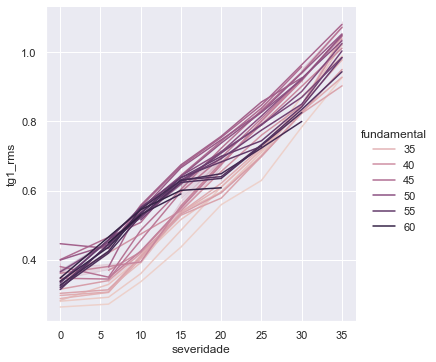

In [46]:
df_tg1_round_normalized = df_tg1_round.copy(deep=True)
df_tg1_round_normalized['tg1_rms'] = df_tg1_round['tg1_rms']/df_tg1_round['fundamental']

sns.relplot(
    data=df_tg1_round_normalized.query('fundamental > 30'), 
    x='severidade', y='tg1_rms', hue='fundamental', kind='line',
);

A normalização melhora bastante a relação de linearidade entre as variáveis. No entando, ao se inverter os eixos, notamos a dificuldade de gerar um modelo adequado, que acerte a severidade de desbalanceamento, pois: 

1. A severidade é uma variavel muito discretizada
2. Em uma mesma faixa de velocidade, valores próximos de aceleraçao tangencial correspondem a severidades muito distintas

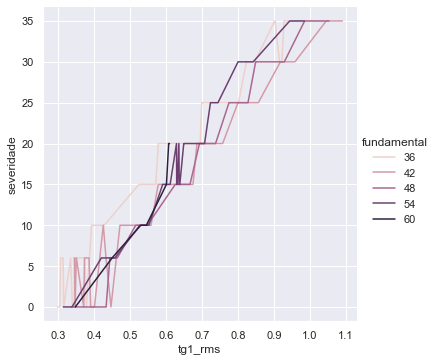

In [47]:
df_tg1_round_normalized = df_tg1_round.copy(deep=True)
df_tg1_round_normalized['tg1_rms'] = df_tg1_round['tg1_rms']/df_tg1_round['fundamental']
df_tg1_round_normalized['fundamental'] = df_tg1_round_normalized['fundamental']//6*6

sns.relplot(
    data=df_tg1_round_normalized.query('fundamental > 30'), 
    y='severidade', x='tg1_rms', hue='fundamental', kind='line',
);

O ideal seria encurtar ainda mais a faixa de valores. Como se vê, a reta de regressão não permite uma função unívoca para cada valor de aceleração tangencial.

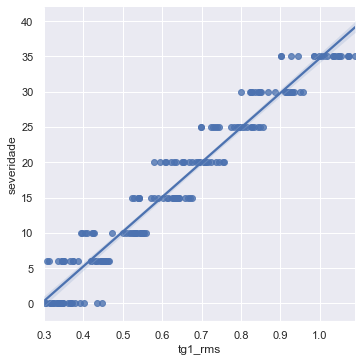

In [48]:
sns.lmplot(
    data=df_tg1_round_normalized.query('fundamental > 30'), 
    y='severidade', x='tg1_rms'
);